In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from orbitize import results, plot
from orbitize.basis import tau_to_tp
from astropy import units as u
from astropy.time import Time
from scipy.stats import norm

"""
using `orbitize_for_betelgeuse` branch of orbitize
"""

# 1A
planet = True
run_name = "planetTrue_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_burn100_total25000000"

# 1B
# planet = False
# run_name = "planetFalse_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_burn100_total25000000"

# 1C
# planet = True
# ecc = True
# run_name = "planetTrue_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_eccfree_burn100_total25000000"

# 1D
# planet = True
# ecc = False
# jit = True
# run_name = "planetTrue_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_fitastromjitter_burn100_total25000000"

# 2A
# planet = True
# run_name = "planetTrue_dvdFalse_renormHIPFalse_fitradioFalse_fithipparcosTrue_burn100_total25000000"

# 2B
# planet = False
# run_name = "planetFalse_dvdFalse_renormHIPFalse_fitradioFalse_fithipparcosTrue_burn100_total25000000"

# 3A
# planet = True
# ecc = False
# run_name = "planetTrue_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosFalse_burn100_total25000000"

# 3B
# planet = False
# run_name = "planetFalse_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosFalse_burn100_total25000000"

# 5A
# planet = True
# run_name = "planetTrue_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_nofirstIAD_burn100_total25000000"

# 5B
# planet = False
# run_name = "planetFalse_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_nofirstIAD_burn100_total25000000"

beetle_results = results.Results()
beetle_results.load_results("results/{}.hdf5".format(run_name))

# create new dir for plots about this run
savedir = "plots/{}".format(run_name)
if not os.path.exists(savedir):
    os.mkdir(savedir)

/home/sblunt/orbitize/orbitize/hipparcos.py:246: SyntaxWarning: invalid escape sequence '\s'
  path_to_iad_file, skiprows=9, sep="\s+", nrows=1
/home/sblunt/orbitize/orbitize/hipparcos.py:260: SyntaxWarning: invalid escape sequence '\s'
  path_to_iad_file, skiprows=5, sep="\s+", nrows=1


In [47]:
# make TeX for paper


def format_post(
    results_obj,
    el_label,
    n_decimals=1,
    degrees=False,
    dont_print_circ_toggle=False,
    pergt5=False,
    perlt5=False,
):
    if type(el_label) is str:
        marginalized_1dpost = results_obj.post[
            :, results_obj.system.param_idx[el_label]
        ]
    else:
        marginalized_1dpost = el_label
    if pergt5:
        marginalized_1dpost = marginalized_1dpost[marginalized_1dpost >= 5] * 365.25
    elif perlt5:
        marginalized_1dpost = marginalized_1dpost[marginalized_1dpost < 5] * 365.25
    quants = np.quantile(marginalized_1dpost, [0.16, 0.50, 0.84])

    if dont_print_circ_toggle:
        return "--"

    if degrees:
        quants = np.degrees(quants)

    med = quants[1]
    up_lim = quants[2] - quants[1]
    lo_lim = quants[1] - quants[0]

    if up_lim == lo_lim:
        if el_label == "ecc1":
            return "=0"

    if np.abs(up_lim - lo_lim) <= 1 / (10 * n_decimals):
        return "${:.{prec}f}\\pm{{{:.{prec}f}}}$".format(med, up_lim, prec=n_decimals)

    formatted_str = "${:.{prec}f}^{{+{:.{prec}f}}}_{{-{:.{prec}f}}}$".format(
        med, up_lim, lo_lim, prec=n_decimals
    )

    return formatted_str


hiper = format_post(beetle_results, "per1", n_decimals=1, pergt5=True)
lowper = format_post(beetle_results, "per1", n_decimals=1, perlt5=True)

period_row = (
    f"P$_{{B}}$ & days & $\mathcal{{U}}[1000,2700]$ & {hiper}\\\\ & & & {lowper} \\\\"
)

plx_str = format_post(beetle_results, "plx", n_decimals=1)
plx_row = f"$\pi$ & mas & $\mathcal{{U}}[0,15]$ & {plx_str} \\\\"

pm_ra_str = format_post(beetle_results, "pm_ra", n_decimals=1)
pm_ra_prior_lo = beetle_results.system.sys_priors[
    beetle_results.system.param_idx["pm_ra"]
].minval
pm_ra_prior_hi = beetle_results.system.sys_priors[
    beetle_results.system.param_idx["pm_ra"]
].maxval
pm_ra_row = "$\\mu_{{\\alpha^{{*}}}}$ & mas yr$^{{-1}}$ & $\mathcal{{U}}[{:.1f},{:.1f}]$ & {} \\\\".format(
    pm_ra_prior_lo, pm_ra_prior_hi, pm_ra_str
)

pm_dec_str = format_post(beetle_results, "pm_dec", n_decimals=1)
pm_dec_prior_lo = beetle_results.system.sys_priors[
    beetle_results.system.param_idx["pm_dec"]
].minval
pm_dec_prior_hi = beetle_results.system.sys_priors[
    beetle_results.system.param_idx["pm_dec"]
].maxval
pm_dec_row = "$\\mu_{{\\delta}}$ & mas yr$^{{-1}}$ & $\mathcal{{U}}[{:.1f},{:.1f}]$ & {} \\\\".format(
    pm_dec_prior_lo, pm_dec_prior_hi, pm_dec_str
)

ra_str = format_post(beetle_results, "alpha0", n_decimals=2)
ra_prior_lo = beetle_results.system.sys_priors[
    beetle_results.system.param_idx["alpha0"]
].minval
ra_prior_hi = beetle_results.system.sys_priors[
    beetle_results.system.param_idx["alpha0"]
].maxval
ra_row = (
    "$\\alpha^{{*}}_{{0}}$ & mas & $\mathcal{{U}}[{:.2f},{:.2f}]$ & {} \\\\".format(
        ra_prior_lo, ra_prior_hi, ra_str
    )
)

dec_str = format_post(beetle_results, "delta0", n_decimals=2)
dec_prior_lo = beetle_results.system.sys_priors[
    beetle_results.system.param_idx["delta0"]
].minval
dec_prior_hi = beetle_results.system.sys_priors[
    beetle_results.system.param_idx["delta0"]
].maxval
dec_row = "$\\delta_{{0}}$ & mas & $\mathcal{{U}}[{:.2f},{:.2f}]$ & {} \\\\".format(
    dec_prior_lo, dec_prior_hi, dec_str
)

m0_str = format_post(beetle_results, "m0", n_decimals=1)
m0_row = "$M_{{A}}$ & M$_{{\\odot}}$ & $\mathcal{{U}}[10,25]$ & {} \\\\".format(m0_str)

m1_str = format_post(beetle_results, "m1", n_decimals=1)
m1_row = "$M_{{B}}$ & M$_{{\\odot}}$ & log$\mathcal{{U}}[0.1,10]$ & {} \\\\".format(
    m1_str
)

ecc_row = "$e_{{B}}$ &  & =0 & \\\\"

W_str = format_post(beetle_results, "pan1", n_decimals=1, degrees=True)
Omega_row = "$\Omega_B$ & deg & $\mathcal{{U}}[0, 2\pi]$ & {} \\\\".format(W_str)


tau_str = format_post(beetle_results, "tau1", n_decimals=2)
tau_row = "$\\tau_B$ &  & $\mathcal{{U}}[0, 1]$ & {} \\\\".format(tau_str)

inc_str = format_post(beetle_results, "inc1", n_decimals=1, degrees=True)
inc_row = "$i_B$ & deg & $\sin{{i}}$ & {} \\\\".format(inc_str)

msini_post = beetle_results.post[:, beetle_results.system.param_idx["m1"]] * np.sin(
    beetle_results.post[:, beetle_results.system.param_idx["inc1"]]
)
msini_str = format_post(None, msini_post, n_decimals=1)
msini_row = "$M_{{B}} \sin{{i_B}}$ & M$_{{\\odot}}$ & & {} \\\\".format(msini_str)

q_post = (
    beetle_results.post[:, beetle_results.system.param_idx["m1"]]
    / beetle_results.post[:, beetle_results.system.param_idx["m0"]]
)
q_post_str = format_post(None, q_post, n_decimals=2)
q_row = "q &  & & {} \\\\".format(q_post_str)


print()
print()
print(plx_row)
print(pm_ra_row)
print(pm_dec_row)
print(ra_row)
print(dec_row)
print(period_row)
print(m0_row)
print(m1_row)
print(ecc_row)
print(Omega_row)
print(tau_row)
print(inc_row)
print("\\hline")  # derived params below
print(msini_row)
print(q_row)

print()
print()

<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:89: SyntaxWarning: invalid escape sequence '\m'
<>:101: SyntaxWarning: invalid escape sequence '\m'
<>:106: SyntaxWarning: invalid escape sequence '\m'
<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:116: SyntaxWarning: invalid escape sequence '\O'
<>:120: SyntaxWarning: invalid escape sequence '\m'
<>:123: SyntaxWarning: invalid escape sequence '\s'
<>:129: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:89: SyntaxWarning: invalid escape sequence '\m'
<>:101: SyntaxWarning: invalid escape sequence '\m'
<>:106: SyntaxWarning: invalid escape sequence '\m'
<>:109: SyntaxWarning:



$\pi$ & mas & $\mathcal{U}[0,15]$ & $5.4\pm{0.9}$ \\
$\mu_{\alpha^{*}}$ & mas yr$^{-1}$ & $\mathcal{U}[17.2,37.8]$ & $24.9\pm{0.1}$ \\
$\mu_{\delta}$ & mas yr$^{-1}$ & $\mathcal{U}[4.8,17.8]$ & $9.5\pm{0.1}$ \\
$\alpha^{*}_{0}$ & mas & $\mathcal{U}[-7.10,7.10]$ & $0.08\pm{0.93}$ \\
$\delta_{0}$ & mas & $\mathcal{U}[-5.80,5.80]$ & $0.70^{+0.91}_{-1.10}$ \\
P$_{B}$ & days & $\mathcal{U}[1000,2700]$ & $2181.4^{+93.5}_{-97.0}$\\ & & & $1655.7\pm{46.3}$ \\
$M_{A}$ & M$_{\odot}$ & $\mathcal{U}[10,25]$ & $17.5^{+5.0}_{-5.1}$ \\
$M_{B}$ & M$_{\odot}$ & log$\mathcal{U}[0.1,10]$ & $2.7^{+0.9}_{-0.7}$ \\
$e_{{B}}$ &  & =0 & \\
$\Omega_B$ & deg & $\mathcal{U}[0, 2\pi]$ & $57.6^{+9.3}_{-9.1}$ \\
$\tau_B$ &  & $\mathcal{U}[0, 1]$ & $0.76\pm{0.11}$ \\
$i_B$ & deg & $\sin{i}$ & $91.6^{+10.4}_{-9.3}$ \\
\hline
$M_{B} \sin{i_B}$ & M$_{\odot}$ & & $2.6^{+0.9}_{-0.7}$ \\
q &  & & $0.16\pm{0.05}$ \\




Make corner plot, secondary mass plot, and period plot:

{'per1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'pm_ra': 7, 'pm_dec': 8, 'alpha0': 9, 'delta0': 10, 'm1': 11, 'm0': 12}


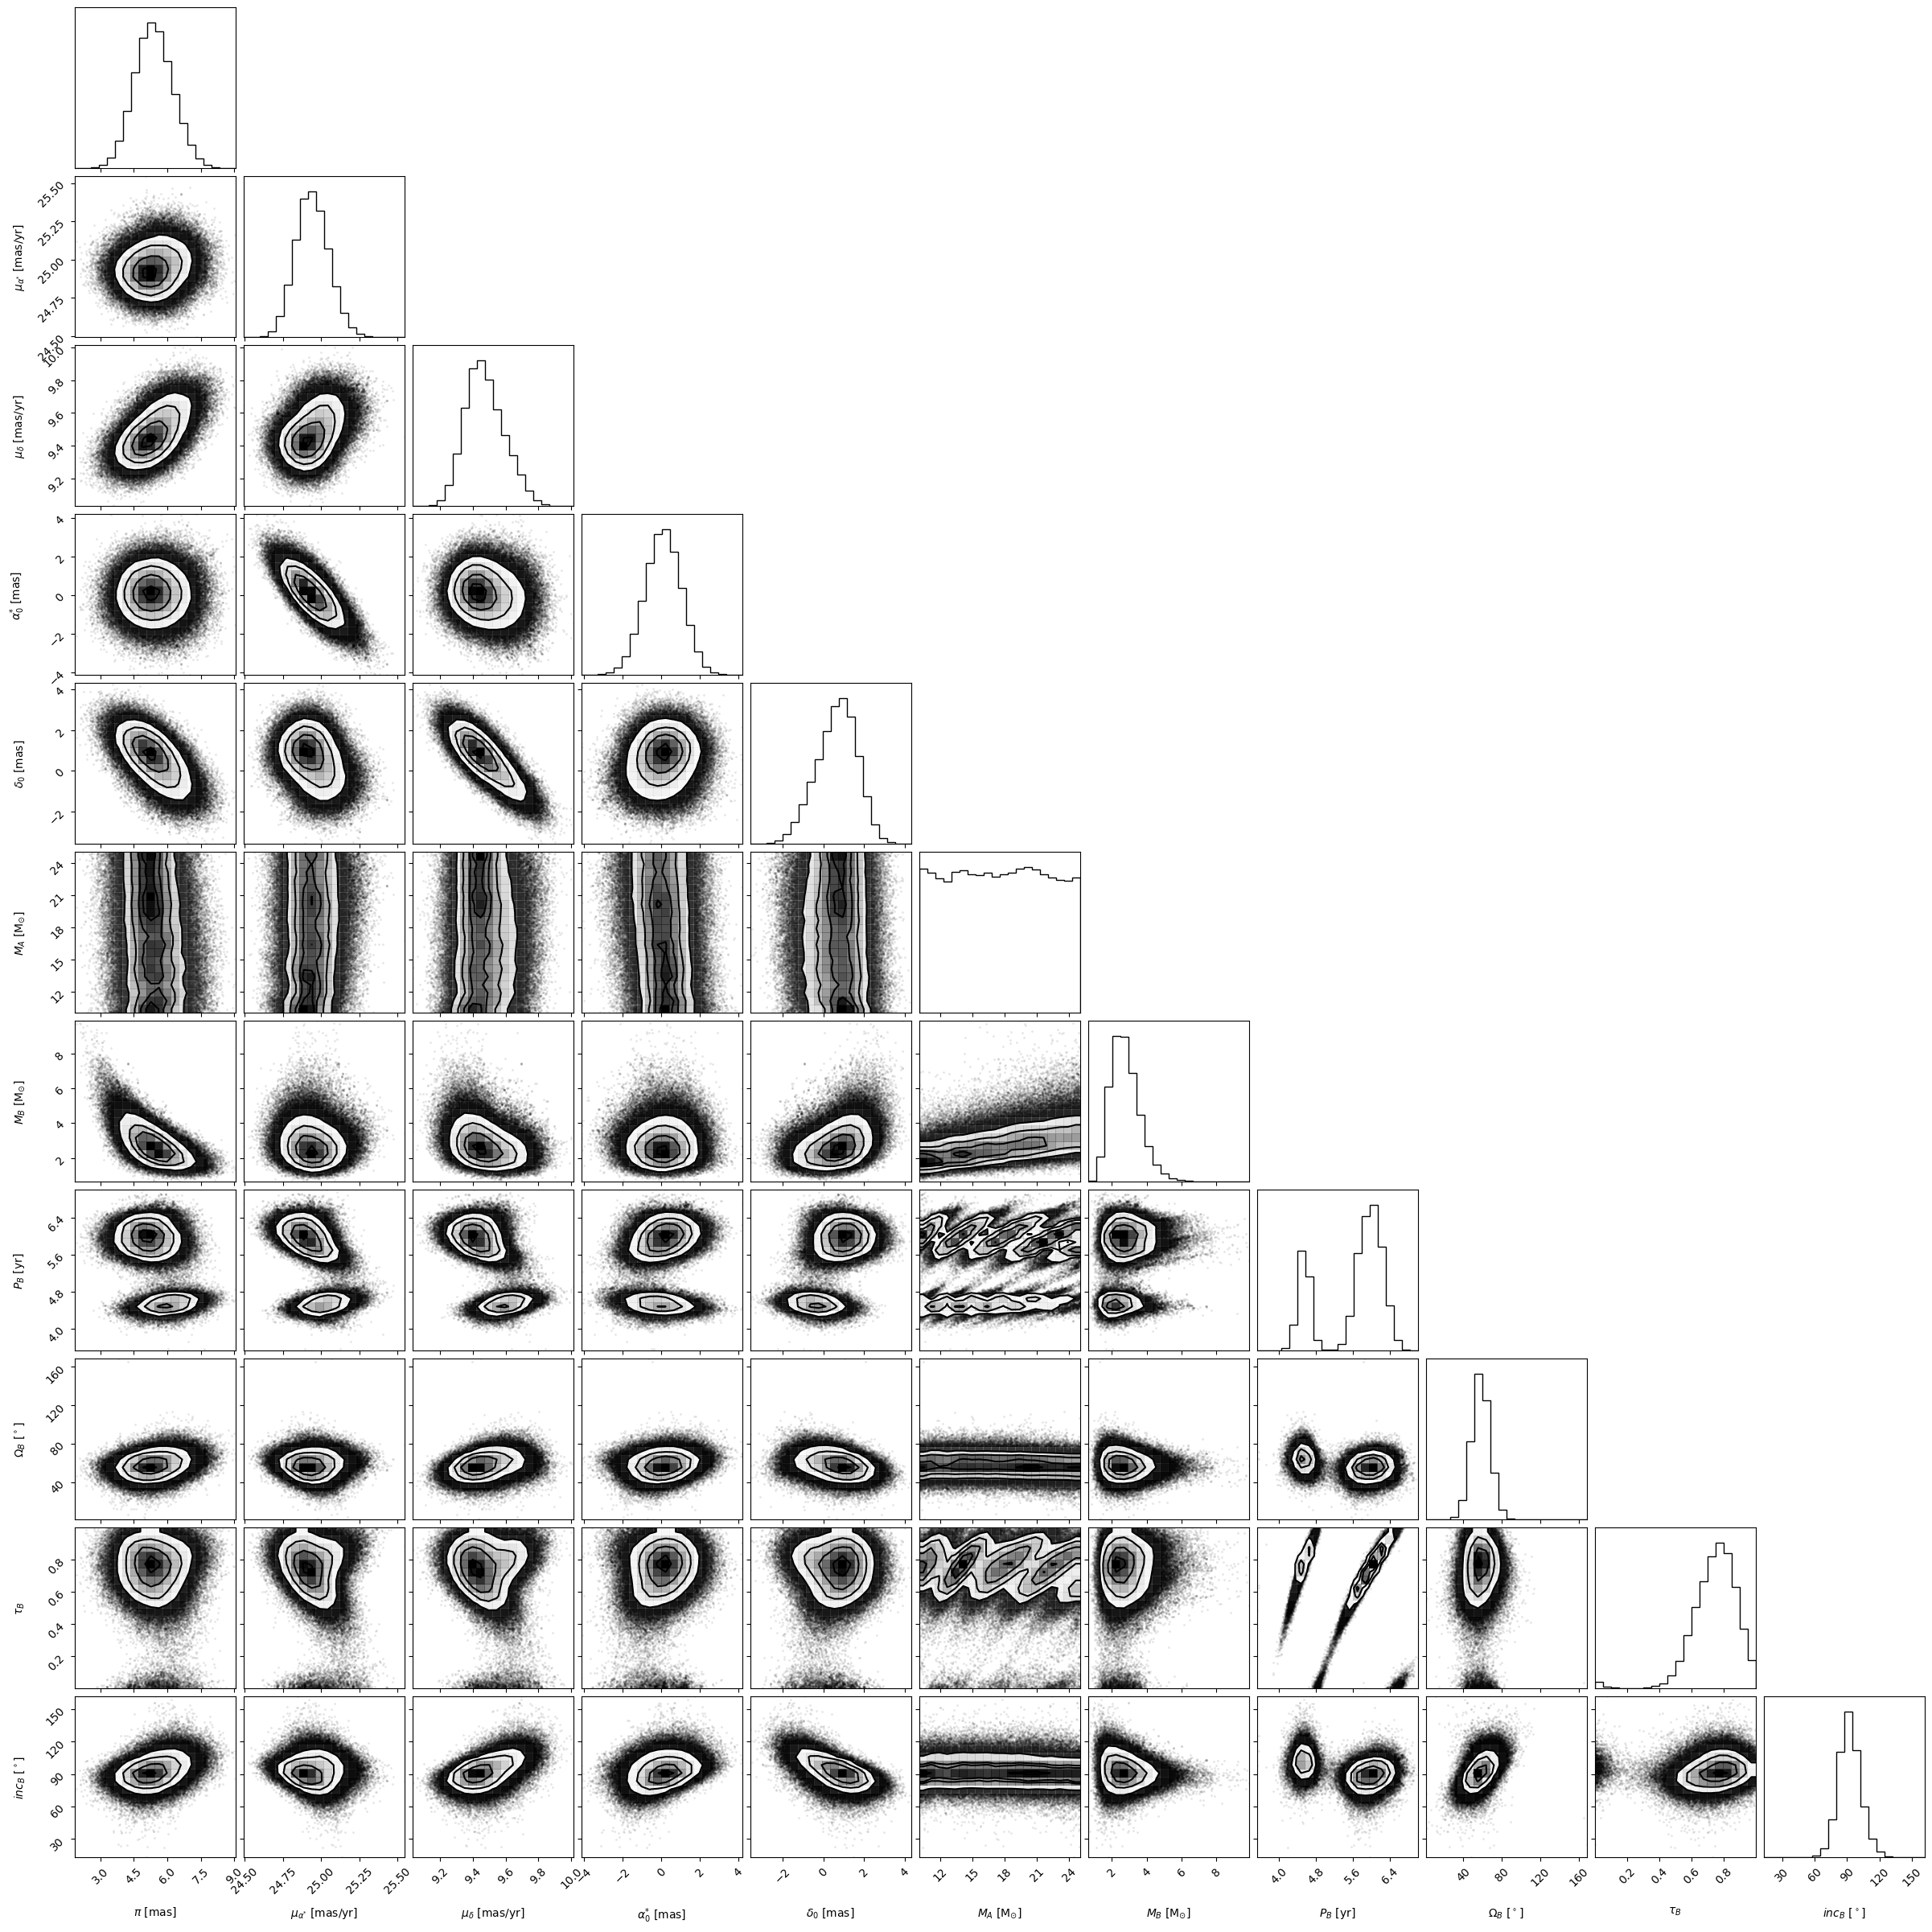

In [2]:
minimal_corner = False

if not planet:
    param_list = ["plx", "pm_ra", "pm_dec", "alpha0", "delta0"]
else:
    param_list = [
        "plx",
        "pm_ra",
        "pm_dec",
        "alpha0",
        "delta0",
        "m0",
        "m1",
        "per1",
        "pan1",
        "tau1",
        "inc1",
    ]
# if ecc:
#     param_list.append("ecc1")
# if jit:
#     param_list.append("sigma_ast")
if minimal_corner:
    param_list = [
        "m1",
        "per1",
        "pan1",
        "tau1",
        "inc1",
    ]


print(beetle_results.param_idx)
fig = plot.plot_corner(beetle_results, param_list=param_list)

if minimal_corner:
    plt.savefig("{}/minimal_corner.png".format(savedir), dpi=250)
else:
    plt.savefig("{}/corner.png".format(savedir), dpi=250)

6.393875698671069
hi:1.053261637322195
lo:1.0361882290558073
59857.94200795391
hi:341.25545924290054
lo:275.90308193878445


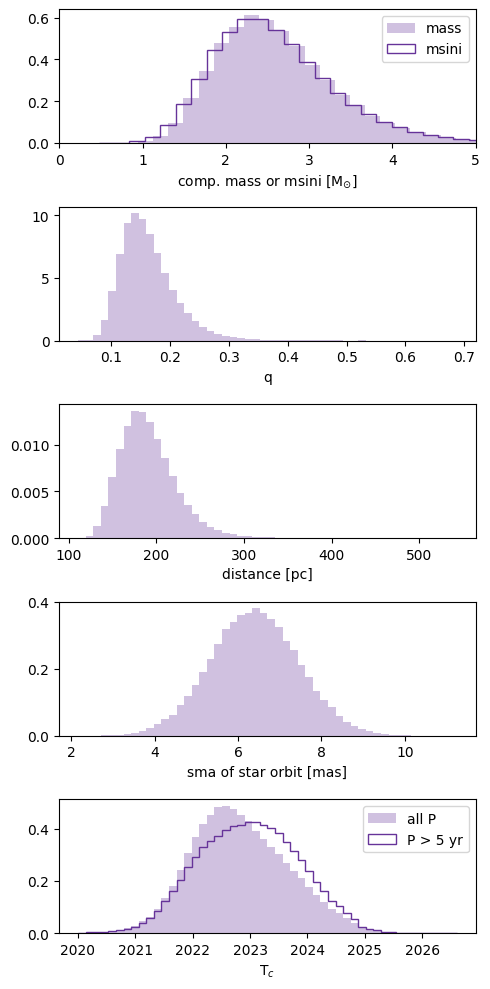

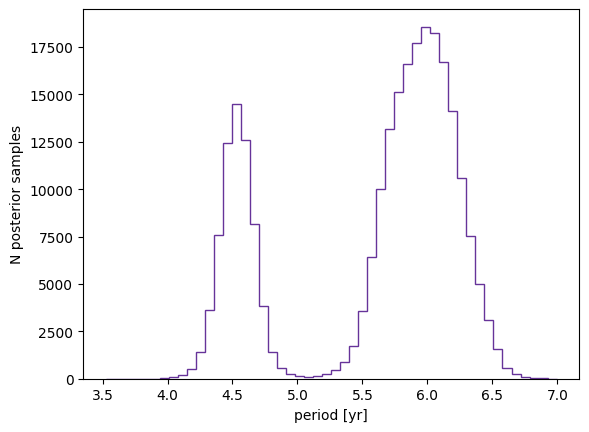

In [55]:
fig, ax = plt.subplots(5, 1, figsize=(5, 10))

m0_mask = (beetle_results.post[:, beetle_results.param_idx["m0"]] > 12) & (
    beetle_results.post[:, beetle_results.param_idx["m0"]] < 20
)
per_mask = beetle_results.post[:, beetle_results.param_idx["per1"]] > 5

mtot = (
    beetle_results.post[:, beetle_results.param_idx["m1"]]
    + beetle_results.post[:, beetle_results.param_idx["m0"]]
)
plx_as = beetle_results.post[:, beetle_results.param_idx["plx"]] * 1e-3
m1_msol = beetle_results.post[:, beetle_results.param_idx["m1"]]


m0 = beetle_results.post[:, beetle_results.param_idx["m0"]]
sma_au = (beetle_results.post[:, beetle_results.param_idx["per1"]] ** 2 * mtot) ** (
    1 / 3
)


ax[0].hist(
    m1_msol[m0_mask],
    bins=50,
    density=True,
    color="rebeccapurple",
    alpha=0.3,
    label="mass",
)
ax[0].hist(
    m1_msol[m0_mask]
    * np.sin(beetle_results.post[:, beetle_results.param_idx["inc1"]][m0_mask]),
    bins=50,
    density=True,
    color="rebeccapurple",
    histtype="step",
    label="msini",
)
ax[0].legend()
ax[0].set_xlim(0, 5)
ax[0].set_xlabel("comp. mass or msini [M$_{{\\odot}}$]")

ax[1].hist(
    beetle_results.post[:, beetle_results.param_idx["m1"]]
    / beetle_results.post[:, beetle_results.param_idx["m0"]],
    bins=50,
    density=True,
    color="rebeccapurple",
    alpha=0.3,
)
ax[1].set_xlabel("q")


# ax[2].hist(
#     sma_au[m0_mask],  # * cst.au / cst.R_sun,
#     bins=50,
#     density=True,
#     label="all P",
#     color="rebeccapurple",
#     alpha=0.3,
# )
# ax[2].hist(
#     sma_au[m0_mask & per_mask],  # * (cst.au / cst.R_sun).to(""),
#     bins=50,
#     density=True,
#     color="rebeccapurple",
#     histtype="step",
#     label="P > 5 yr",
# )
# ax[2].legend()
# ax[2].set_xlabel("sma [au]")

ax[2].hist(1 / plx_as, bins=50, density=True, color="rebeccapurple", alpha=0.3)
ax[2].set_xlabel("distance [pc]")

dist_pc = 1 / plx_as

sma_star_mas = (
    (
        (
            sma_au[m0_mask & per_mask]
            * m1_msol[m0_mask & per_mask]
            / mtot[m0_mask & per_mask]
        )
        * u.au
        / (dist_pc[m0_mask & per_mask] * u.pc)
    ).to("")
    * 206265.0
    * 1e3
)

sma_quants = np.quantile(sma_star_mas, [0.16, 0.5, 0.84])
print(sma_quants[1])
print("hi:{}".format(sma_quants[2] - sma_quants[1]))
print("lo:{}".format(sma_quants[1] - sma_quants[0]))


ax[3].hist(sma_star_mas, bins=50, density=True, color="rebeccapurple", alpha=0.3)

ax[3].set_xlabel("sma of star orbit [mas]")


tP_post = tau_to_tp(
    beetle_results.post[:, beetle_results.param_idx["tau1"]],
    beetle_results.tau_ref_epoch,
    beetle_results.post[:, beetle_results.param_idx["per1"]],
)
ecc = 0
aop = np.pi
per_post_days = beetle_results.post[:, beetle_results.param_idx["per1"]] * 365.25

# conversion code stolen from radvel
f = np.pi / 2 - aop  # true anomaly during transit
ee = 2 * np.arctan(np.tan(f / 2) * np.sqrt((1 - ecc) / (1 + ecc)))  # eccentric anomaly

tc_post = tP_post + per_post_days / (2 * np.pi) * (
    ee - ecc * np.sin(ee)
)  # time of conjunction


after_date = after_date = Time(2020, format="decimalyear").mjd
num_periods = (after_date - tc_post) / per_post_days
num_periods = np.ceil(num_periods).astype(int)
tc_post += num_periods * per_post_days

ax[4].hist(
    Time(tc_post, format="mjd").decimalyear,
    bins=50,
    color="rebeccapurple",
    density=True,
    alpha=0.3,
    label="all P",
)
ax[4].hist(
    Time(tc_post[per_mask], format="mjd").decimalyear,
    bins=50,
    color="rebeccapurple",
    density=True,
    histtype="step",
    label="P > 5 yr",
)

tc_quants = np.quantile(tc_post, [0.16, 0.5, 0.84])
print(tc_quants[1])
print("hi:{}".format(tc_quants[2] - tc_quants[1]))
print("lo:{}".format(tc_quants[1] - tc_quants[0]))

ax[4].legend()
ax[4].set_xlabel("T$_c$")

plt.tight_layout()
plt.savefig("{}/mass_period.png".format(savedir), dpi=250)

fig = plt.figure()
plt.hist(
    beetle_results.post[:, beetle_results.param_idx["per1"]],
    histtype="step",
    bins=50,
    color="rebeccapurple",
)
plt.xlabel("period [yr]")
plt.ylabel("N posterior samples")
plt.savefig(f"{savedir}/period.png", dpi=250)

In [ ]:
# show jitter/m1 correlation
import corner

sigma_ast = beetle_results.post[:, -1]

to_plot = np.array(
    [
        sigma_ast,
        beetle_results.post[:, beetle_results.system.param_idx["m1"]],
        beetle_results.post[:, beetle_results.system.param_idx["per1"]],
    ],
)
corner.corner(
    to_plot.T,
    labels=["$\sigma_{ast}$", "M$_1$ [M$_{\odot}$]", "P [yr]"],
)
plt.savefig(f"{savedir}/jitter_mass.png", dpi=250)

<>:63: SyntaxWarning: invalid escape sequence '\p'
<>:63: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1552633/845376170.py:63: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel("$\pi$ [mas]")
/tmp/ipykernel_1552633/845376170.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  topax.set_xticklabels(np.round(dist_xtick_labels, decimals=1))


[4.53205536 5.35697412 6.2394683 ]


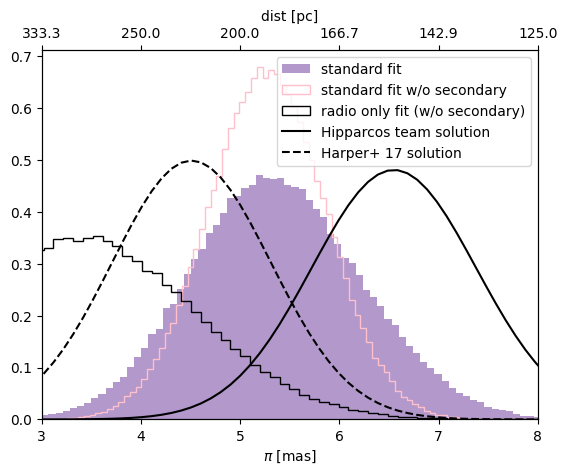

In [15]:
# compare distance for two different fits

# fits to compare
run1A = "planetTrue_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_burn100_total25000000"
run1B = "planetFalse_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_burn100_total25000000"
run3B = "planetFalse_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosFalse_burn100_total25000000"

results_1B = results.Results()
results_1B.load_results("results/{}.hdf5".format(run1B))

results_1A = results.Results()
results_1A.load_results("results/{}.hdf5".format(run1A))


results_3B = results.Results()
results_3B.load_results("results/{}.hdf5".format(run3B))


plt.figure()
hts, bins, _ = plt.hist(
    results_1A.post[:, beetle_results.system.param_idx["plx"]],
    bins=100,
    label="standard fit",
    density=True,
    color="rebeccapurple",
    alpha=0.5,
)
hts, bins, _ = plt.hist(
    results_1B.post[:, beetle_results.system.param_idx["plx"]],
    bins=100,
    label="standard fit w/o secondary",
    density=True,
    color="pink",
    histtype="step",
)
hts, bins, _ = plt.hist(
    results_3B.post[:, beetle_results.system.param_idx["plx"]],
    bins=100,
    label="radio only fit (w/o secondary)",
    density=True,
    color="k",
    histtype="step",
)

# overplot Hipparcos team solution
plt.plot(
    bins,
    norm.pdf(bins, 6.55, 0.83),
    label="Hipparcos team solution",
    color="k",
)
plt.plot(
    bins,
    norm.pdf(bins, 4.51, 0.80),
    label="Harper+ 17 solution",
    color="k",
    ls="--",
)


plt.legend()
plt.xlim(3, 8)
plt.xlabel("$\pi$ [mas]")

dist_xtick_labels = 1e3 / plt.xticks()[0]

ax = plt.gca()
topax = ax.twiny()
topax.set_xticklabels(np.round(dist_xtick_labels, decimals=1))
topax.set_xlabel("dist [pc]")


# topax.set_xticklabels(1 / np.array())


plt.ylabel("prob. density")
plt.savefig("plots/plx_compare.png", dpi=250)

plx_quantiles = np.quantile(
    beetle_results.post[:, beetle_results.system.param_idx["plx"]], [0.16, 0.5, 0.84]
)
print(plx_quantiles)

<>:103: SyntaxWarning: invalid escape sequence '\m'
<>:104: SyntaxWarning: invalid escape sequence '\m'
<>:103: SyntaxWarning: invalid escape sequence '\m'
<>:104: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1552633/967856023.py:103: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel("$\mu_{\\alpha^{*}}$  [mas/yr]")
/tmp/ipykernel_1552633/967856023.py:104: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel("$\mu_{\\delta}$ [mas/yr]")


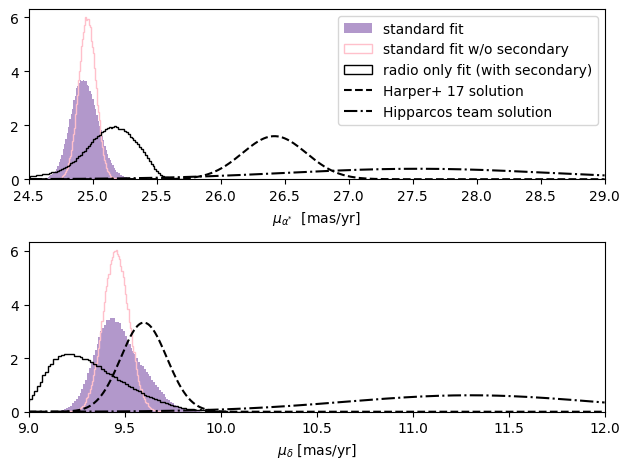

In [12]:
# compare proper motion for three different fits

# fits to compare
run1A = "planetTrue_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_burn100_total25000000"
run1B = "planetFalse_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_burn100_total25000000"
run3A = "planetTrue_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosFalse_burn100_total25000000"


results_1B = results.Results()
results_1B.load_results("results/{}.hdf5".format(run1B))

results_1A = results.Results()
results_1A.load_results("results/{}.hdf5".format(run1A))

results_3 = results.Results()
results_3.load_results("results/{}.hdf5".format(run3A))


fig, ax = plt.subplots(2, 1)
hts, bins, _ = ax[0].hist(
    results_1A.post[:, beetle_results.system.param_idx["pm_ra"]],
    bins=100,
    label="standard fit",
    density=True,
    color="rebeccapurple",
    alpha=0.5,
)
hts, bins, _ = ax[0].hist(
    results_1B.post[:, beetle_results.system.param_idx["pm_ra"]],
    bins=100,
    label="standard fit w/o secondary",
    density=True,
    color="pink",
    histtype="step",
)
hts, bins, _ = ax[0].hist(
    results_3.post[:, beetle_results.system.param_idx["pm_ra"]],
    bins=100,
    label="radio only fit (with secondary)",
    density=True,
    color="k",
    histtype="step",
)
ra_bins2plot = np.linspace(24.5, 29, int(1e3))
ax[0].plot(
    ra_bins2plot,
    norm.pdf(ra_bins2plot, 26.42, 0.25),
    label="Harper+ 17 solution",
    color="k",
    ls="--",
)
ax[0].plot(
    ra_bins2plot,
    norm.pdf(ra_bins2plot, 27.54, 1.03),
    label="Hipparcos team solution",
    color="k",
    ls="-.",
)
ax[0].legend()

hts, bins, _ = ax[1].hist(
    results_1A.post[:, beetle_results.system.param_idx["pm_dec"]],
    bins=100,
    # label="standard fit",
    density=True,
    color="rebeccapurple",
    alpha=0.5,
)
hts, bins, _ = ax[1].hist(
    results_1B.post[:, beetle_results.system.param_idx["pm_dec"]],
    bins=100,
    # label="standard fit w/o secondary",
    density=True,
    color="pink",
    histtype="step",
)
hts, bins, _ = ax[1].hist(
    results_3.post[:, beetle_results.system.param_idx["pm_dec"]],
    bins=100,
    # label="radio only fit (with secondary)",
    density=True,
    color="k",
    histtype="step",
)
dec_bins2plot = np.linspace(9, 12, int(1e3))
ax[1].plot(
    dec_bins2plot,
    norm.pdf(dec_bins2plot, 9.60, 0.12),
    # label="Harper+ 17 solution",
    color="k",
    ls="--",
)
ax[1].plot(
    dec_bins2plot,
    norm.pdf(dec_bins2plot, 11.30, 0.65),
    # label="Hipparcos team solution",
    color="k",
    ls="-.",
)

ax[0].set_xlim(24.5, 29)
ax[1].set_xlim(9, 12)
ax[0].set_xlabel("$\mu_{\\alpha^{*}}$  [mas/yr]")
ax[1].set_xlabel("$\mu_{\\delta}$ [mas/yr]")
plt.tight_layout()
plt.savefig("plots/pm_compare.png", dpi=250)

In [ ]:
# make MCMC convergence plots
params = {"per1": "per"}
for param in params.keys():
    chn = beetle_results.post[:, beetle_results.system.param_idx[param]] * 365.25

    num_walkers = 1000
    thin = 100
    n_steps = len(chn) // num_walkers
    chn = chn.reshape((num_walkers, n_steps))

    walkers_to_plot = np.random.choice(num_walkers, size=100, replace=False)
    plt.figure(figsize=(4, 2))
    chop_after = 0
    for w in walkers_to_plot:
        plt.plot(chn[w, :][chop_after:], color="k", alpha=0.01)
    plt.xlabel("step number / {}".format(thin * num_walkers))
    plt.ylabel(params[param])
    plt.savefig(
        "{}/per_chains.png".format(savedir),
        dpi=250,
    )

Compare the PAN of the orbit with the star's rotation axis:

In [ ]:
from scipy.stats import norm

"""
Ref for PAN of Betelgeuse:
https://www.aanda.org/articles/aa/full_html/2018/01/aa31761-17/T4.html
"""

beetle_rot_pan = [
    (48.0, 1.1),
    (47.6, 1.1),
    (49.5, 1.0),
    (47.9, 1.0),
    (51.9, 1.3),
    (50.6, 1.0),
    (45.5, 1.0),
    (45.8, 1.0),
]

fig, ax = plt.subplots(2, 1)
ax[0].hist(np.degrees(inc_post), bins=50, color="rebeccapurple", density=True)
ax[0].axvline(90, color="hotpink", ls="-.", label="edge on")
ax[0].legend()
ax[1].hist(np.degrees(pan_post) % 180, bins=50, color="rebeccapurple", density=True)

xs = np.linspace(25, 60, 200)
for i, (pan_est, pan_unc) in enumerate(beetle_rot_pan):
    gaussian_pdf = norm(pan_est, pan_unc).pdf(xs)
    ax[1].fill_between(
        xs,
        gaussian_pdf / 10,
        np.zeros_like(xs),
        color="hotpink",
        alpha=0.2,
        label="Kervella+ 17 meas.",
    )
    if i == 0:
        ax[1].legend()
ax[0].set_xlabel("inc [deg]")
ax[1].set_xlabel("$\Omega_{{\\mathrm{{B}}}}$ % 180 [deg]")
plt.tight_layout()
plt.savefig("{}/mutual_inc.png".format(savedir), dpi=250)

What are the other peaks in the period posterior? Are they harmonics? Is it the length of the Hipparcos dataset?

In [ ]:
from astropy.timeseries import LombScargle

per_post = beetle_results.post[:, beetle_results.param_idx["per1"]] * 365.25


# total length of dataset
data_len = np.max(beetle_results.system.data_table["epoch"]) - np.min(
    beetle_results.system.data_table["epoch"]
)

# observation:
# - the peak at 3500d is sorta close to data_len / 4, and that peak is
#   nowhere near as high as the other two peaks (in the most converged version of my +planet fit)

# plot the window function
fig, ax = plt.subplots()
radio_epochs = beetle_results.system.data_table["epoch"]
hipparcos_epochs = beetle_results.system.hipparcos_IAD.epochs_mjd
all_epochs = np.sort(np.unique(np.concatenate([radio_epochs, hipparcos_epochs])))


myls = LombScargle(all_epochs, np.ones_like(all_epochs))
freq, power = myls.autopower(
    minimum_frequency=1 / 3500.0,
    maximum_frequency=1 / 1000.0,
    samples_per_peak=3000,
)

plt.plot(1 / freq, power / 8e2, color="rebeccapurple", lw=3, label="window function")
# plt.plot(freq - 0.00007, power * 5000, color="green")
plt.hist(per_post, alpha=0.5, density=True, bins=100, label="standard fit posterior")
print(
    "Maximum of the window function occurs at {:.2f} d.".format(
        1 / freq[np.argmax(power)]
    )
)

results_3A = results.Results()
results_3A.load_results(
    "results/planetTrue_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosFalse_burn100_total25000000.hdf5"
)
per_post_3A = results_3A.post[:, beetle_results.param_idx["per1"]] * 365.25
plt.hist(
    per_post_3A,
    histtype="step",
    density=True,
    bins=100,
    label="radio-only fit posterior",
    color="rebeccapurple",
)


# ax.axvline(420 * 3, label="N * 420d", ls="--", color="red")
ax.axvline(416 * 4, ls="--", color="hotpink", label="4 * 416 d")
# ax.axvline(180, ls="--", color="red")
# ax.axvline(420 * 5, ls="--", color="red")
# ax.axvline(420 * 6, ls="--", color="red")
# ax.axvline(420 * 7, ls="--", color="red")
# ax.axvline(420 * 8, ls="--", color="red")
plt.legend()
plt.xlim(1300, 2500)
plt.xlabel("period [d]")
plt.ylabel("relative prob.")
plt.savefig("{}/period_window.png".format(savedir), dpi=250)

# observations:
# - at shorter periods, the window function has strong peaks at ~180 d, ~250 d,
#   and at longer periods, it's got strong peaks at 1800 and 1500 d.
# - I've tried plotting the window function and the actual posterior in
#   frequency space to see if the window function structure gets imprinted
#   on the posterior, but it doesn't line up exactly.


def print_alias(samp_per, actual_per):
    alias_per = 1 / (1 / samp_per - 1 / actual_per)
    print(alias_per)


print_alias(180, 420.0)